In [1]:
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', version = 1, return_X_y=True)
X = X.values
y = y.astype(int).values

In [2]:
print(X.shape)
print(y.shape)
# 28 X 28 개의 픽셀(784) 이미지 700000개

(70000, 784)
(70000,)


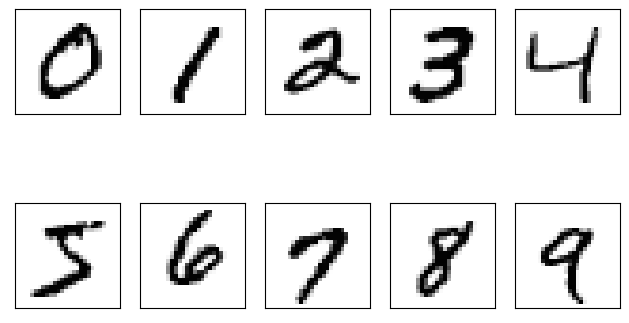

In [3]:
#같은 글씨체로 0부터 9까지
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey = True)
ax = ax.flatten()
for i in range(10):
    img = X[y == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

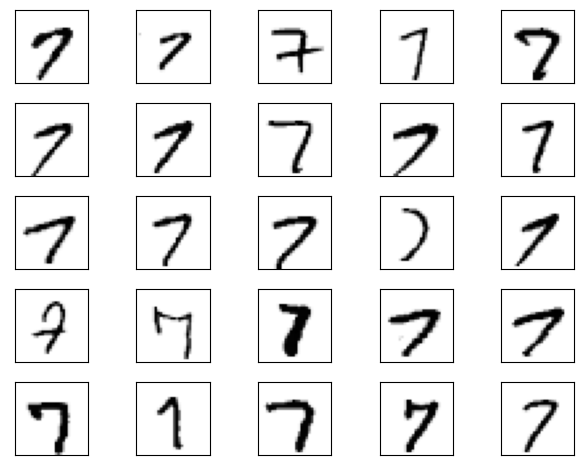

In [4]:
#25개의 글씨체로 7의 숫자
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
    img = X[y == 7][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [5]:
# 훈련세트, 테스트세트 나누기
from sklearn.model_selection import train_test_split
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=10000, random_state=123, stratify=y
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=5000, random_state=123, stratify=y_temp
)

In [6]:
import numpy as np
# 로지스틱 시그모이드 활성화 함수를 계산하는 함수
def sigmoid(z):
    z = np.clip(z, -500, 500)  # 입력값을 -500에서 500 사이로 제한
    return 1.0 / (1.0 + np.exp(-z))
#정수 클래스 레이블 배열을 원-한 인코딩된 레이블로 변환하는 함수
def int_to_onehot(y, num_labels):
    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, val] = 1
    return ary

In [7]:
class NeuralNetMLP:
    def __init__(self, num_features, num_hidden, num_classes, random_seed=123): #num_feature, num_hidden, num_classes = 입력 특성의 수, 은닉층의 뉴련 수, 출력 클래스 수
        super().__init__()
        
        self.num_classes = num_classes
        
        #은닉층
        rng = np.random.RandomState(random_seed)
        
        #은닉층 가중치 행렬
        self.weight_h = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden, num_features)
        )
        #은닉층의 편향 벡터
        self.bias_h = np.zeros(num_hidden)
        
        #출력층
        self.weight_out = rng.normal(
            loc=0.0, scale=0.1, size=(num_classes, num_hidden)
        )
        self.bias_out = np.zeros(num_classes)
        #앞에의 가중치를 사용해서 어떻게 예측을 만드는지
    def forward(self, x):
        # 은닉층
        # 입력 차원 : [n_examples, n_features]
        #           dot [n_hidden, n_features].T
        # 출력 차원 : [n_examples, n_hidden]
        z_h = np.dot(x, self.weight_h.T) + self.bias_h
        a_h = sigmoid(z_h)

        # 출력층
        # 입력 차원 : [n_examples, n_hidden]
        #           dot [n_hidden, n_hidden].T
        # 출력 차원 : [n_examples, n_classes]
        z_out = np.dot(a_h, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)
        return a_h, a_out
    #역전파를 통해 신경망의 가중치와 절편 파라미터를 업데이트 하는 backworad 메서드
    def backward(self, x, a_h, a_out, y):

        #########################
        ### 출력층 가중치
        #########################

        # 원-핫 인코딩
        y_onehot = int_to_onehot(y, self.num_classes)

        # 파트 1: dLoss/dOutWeights
        ## = dLoss/dOutAct * dOutAct/dOutNet * dOutNet/dOutWeight
        ## 재사용을 위해 DeltaOut = dLoss/dOutAct * dOutAct/dOutNet

        # 입력/출력 차원: [n_examples, n_classes]
        d_loss__d_a_out = 2.*(a_out - y_onehot) / y.shape[0]

        # 입력/출력 차원: [n_examples, n_classes]
        d_a_out__d_z_out = a_out * (1. - a_out) # sigmoid derivative

        # 출력 차원: [n_examples, n_classes]
        delta_out = d_loss__d_a_out * d_a_out__d_z_out # "delta (rule) placeholder"

        # 출력 가중치를 위한 그레이디언트

        # [n_examples, n_hidden]
        d_z_out__dw_out = a_h

        # 입력 차원: [n_classes, n_examples] dot [n_examples, n_hidden]
        # 출력 차원: [n_classes, n_hidden]
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out) #가중치
        d_loss__db_out = np.sum(delta_out, axis=0) #편향


        #################################
        # 파트 2: dLoss/dHiddenWeights
        ## = DeltaOut * dOutNet/dHiddenAct * dHiddenAct/dHiddenNet * dHiddenNet/dWeight

        # [n_classes, n_hidden]
        d_z_out__a_h = self.weight_out

        # 출력 차원: [n_examples, n_hidden]
        d_loss__a_h = np.dot(delta_out, d_z_out__a_h)

        # [n_examples, n_hidden]
        d_a_h__d_z_h = a_h * (1. - a_h) # sigmoid derivative

        # [n_examples, n_features]
        d_z_h__d_w_h = x

        # 출력 차원: [n_hidden, n_features]
        d_loss__d_w_h = np.dot((d_loss__a_h * d_a_h__d_z_h).T, d_z_h__d_w_h) #은닉층의 가중치
        d_loss__d_b_h = np.sum((d_loss__a_h * d_a_h__d_z_h), axis=0) #은닉층의 편향

        return (d_loss__dw_out, d_loss__db_out,
                d_loss__d_w_h, d_loss__d_b_h)
        
        # 역전파 알고리즘을 구현하여 가중치 및 절편 파라미터에 대한 손실의 그레이디언트를 계산

In [8]:
# 모델 만들기
model = NeuralNetMLP(num_features=28*28,
                     num_hidden=50,
                     num_classes=10)

### 신경망 훈련 루프 코딩

In [9]:
# 데이터셋을 받아 확률적 경사 하강법 훈련을 위해 원하는 크기의 미니 배치로 나눈다
# 메모리 제한 때문에 미니 배치
import numpy as np

num_epochs = 50
minibatch_size = 100


def minibatch_generator(X, y, minibatch_size):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    for start_idx in range(0, indices.shape[0] - minibatch_size
                           + 1, minibatch_size):
        batch_idx = indices[start_idx:start_idx + minibatch_size]

        yield X[batch_idx], y[batch_idx]

In [10]:
# 의도한대로 작동학고 원하는 크기의 미니 배치를 생성하는지 확인하기 위해
# 훈련 에포크를 반복합니다.
for i in range(num_epochs):

    # 미니 배치를 반복합니다.
    minibatch_gen = minibatch_generator(
        X_train, y_train, minibatch_size)

    for X_train_mini, y_train_mini in minibatch_gen:

        break

    break

print(X_train_mini.shape)
print(y_train_mini.shape)

# 100인 미니 배치 반환

(100, 784)
(100,)


In [11]:
#MSE 손실함수
def mse_loss(targets, probas, num_labels=10):
    onehot_targets = int_to_onehot(targets, num_labels=num_labels)
    return np.mean((onehot_targets - probas)**2)

#정확도 함수
def accuracy(targets, predicted_labels):
    return np.mean(predicted_labels == targets)

In [12]:
#함수를 테스트하고 모델의 검증 세트 MSE와 정확도 계산
_, probas = model.forward(X_valid)
mse = mse_loss(y_valid, probas)

predicted_labels = np.argmax(probas, axis=1) # 예측 클래스 레이블을 얻게 됨
acc = accuracy(y_valid, predicted_labels) # 실제 레이블과 비교하여 정확도 계산

print(f'검증 세트 MSE: {mse:.1f}')
print(f'검증 세트 정확도: {acc*100:.1f}%')

검증 세트 MSE: 0.2
검증 세트 정확도: 11.2%


In [13]:
# 신경망(mnet) 성능평가
def compute_mse_and_acc(nnet, X, y, num_labels=10, minibatch_size=100):
    mse, correct_pred, num_examples = 0., 0, 0 # mse : 평균 제곱오차
    minibatch_gen = minibatch_generator(X, y, minibatch_size)

    for i, (features, targets) in enumerate(minibatch_gen):

        _, probas = nnet.forward(features)
        predicted_labels = np.argmax(probas, axis=1)

        onehot_targets = int_to_onehot(targets, num_labels=num_labels)
        loss = np.mean((onehot_targets - probas)**2)
        correct_pred += (predicted_labels == targets).sum()

        num_examples += targets.shape[0]
        mse += loss

    mse = mse/i
    acc = correct_pred/num_examples
    return mse, acc

In [14]:
mse, acc = compute_mse_and_acc(model, X_valid, y_valid)
print(f'검증 세트 MSE: {mse:.1f}')
print(f'검증 세트 정확도: {acc*100:.1f}%')

검증 세트 MSE: 0.2
검증 세트 정확도: 11.2%


In [15]:
def train(model, X_train, y_train, X_valid, y_valid, num_epochs,
          learning_rate=0.1):

    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []

    for e in range(num_epochs):

        # 미니 배치를 반복합니다.
        minibatch_gen = minibatch_generator(
            X_train, y_train, minibatch_size)

        for X_train_mini, y_train_mini in minibatch_gen:

            #### 출력 계산 ####
            a_h, a_out = model.forward(X_train_mini)

            #### 그레이디언트 계산 ####
            d_loss__d_w_out, d_loss__d_b_out, d_loss__d_w_h, d_loss__d_b_h = \
                model.backward(X_train_mini, a_h, a_out, y_train_mini)

            #### 가중치 업데이트 ####
            model.weight_h -= learning_rate * d_loss__d_w_h
            model.bias_h -= learning_rate * d_loss__d_b_h
            model.weight_out -= learning_rate * d_loss__d_w_out
            model.bias_out -= learning_rate * d_loss__d_b_out

        #### 에포크 로깅 ####
        train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train)
        valid_mse, valid_acc = compute_mse_and_acc(model, X_valid, y_valid)
        train_acc, valid_acc = train_acc*100, valid_acc*100
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)
        print(f'에포크: {e+1:03d}/{num_epochs:03d} '
              f'| 훈련 MSE: {train_mse:.2f} '
              f'| 훈련 정확도: {train_acc:.2f}% '
              f'| 검증 정확도: {valid_acc:.2f}%')

    return epoch_loss, epoch_train_acc, epoch_valid_acc

In [16]:
np.random.seed(123) # 훈련 세트 셔플링을 위해

epoch_loss, epoch_train_acc, epoch_valid_acc = train(
    model, X_train, y_train, X_valid, y_valid,
    num_epochs=50, learning_rate=0.1)

에포크: 001/050 | 훈련 MSE: 0.04 | 훈련 정확도: 80.78% | 검증 정확도: 80.76%
에포크: 002/050 | 훈련 MSE: 0.03 | 훈련 정확도: 86.46% | 검증 정확도: 86.30%
에포크: 003/050 | 훈련 MSE: 0.02 | 훈련 정확도: 87.55% | 검증 정확도: 87.38%
에포크: 004/050 | 훈련 MSE: 0.02 | 훈련 정확도: 88.78% | 검증 정확도: 89.14%
에포크: 005/050 | 훈련 MSE: 0.02 | 훈련 정확도: 89.00% | 검증 정확도: 89.04%
에포크: 006/050 | 훈련 MSE: 0.02 | 훈련 정확도: 89.84% | 검증 정확도: 89.38%
에포크: 007/050 | 훈련 MSE: 0.02 | 훈련 정확도: 90.17% | 검증 정확도: 89.84%
에포크: 008/050 | 훈련 MSE: 0.02 | 훈련 정확도: 90.16% | 검증 정확도: 89.94%
에포크: 009/050 | 훈련 MSE: 0.02 | 훈련 정확도: 90.65% | 검증 정확도: 90.96%
에포크: 010/050 | 훈련 MSE: 0.02 | 훈련 정확도: 91.10% | 검증 정확도: 90.88%
에포크: 011/050 | 훈련 MSE: 0.02 | 훈련 정확도: 90.57% | 검증 정확도: 90.64%
에포크: 012/050 | 훈련 MSE: 0.02 | 훈련 정확도: 91.03% | 검증 정확도: 90.88%
에포크: 013/050 | 훈련 MSE: 0.02 | 훈련 정확도: 91.19% | 검증 정확도: 91.40%
에포크: 014/050 | 훈련 MSE: 0.01 | 훈련 정확도: 91.18% | 검증 정확도: 90.98%
에포크: 015/050 | 훈련 MSE: 0.01 | 훈련 정확도: 91.51% | 검증 정확도: 91.58%
에포크: 016/050 | 훈련 MSE: 0.01 | 훈련 정확도: 91.92% | 검증 정확도: 91.34%
에포크: 017

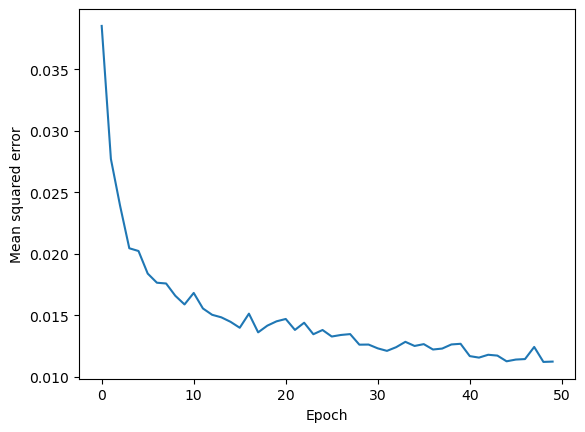

In [17]:
plt.plot(range(len(epoch_loss)), epoch_loss)
plt.ylabel('Mean squared error')
plt.xlabel('Epoch')
#plt.savefig('figures/11_07.png', dpi=300)
plt.show()
# 훈련 에포크에 따른 MSE 그래프

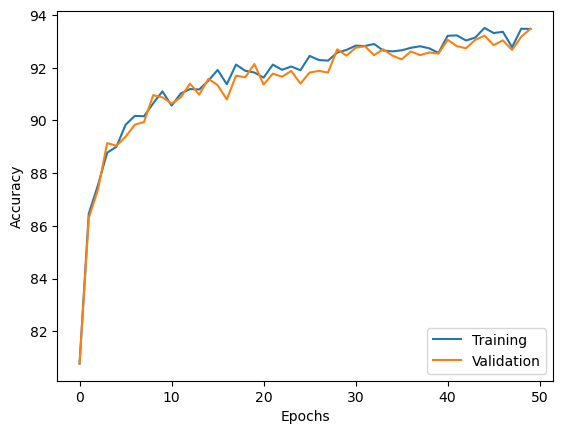

In [18]:
plt.plot(range(len(epoch_train_acc)), epoch_train_acc,
         label='Training')
plt.plot(range(len(epoch_valid_acc)), epoch_valid_acc,
         label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
#plt.savefig('figures/11_08.png', dpi=300)
plt.show()
# 훈련정확도와 검증 정확도 값이 거의 동일하다가 과대적합되기 시작함

In [19]:
test_mse, test_acc = compute_mse_and_acc(model, X_test, y_test)
print(f'테스트 정확도: {test_acc*100:.2f}%')

테스트 정확도: 92.87%


In [20]:
X_test_subset = X_test[:1000, :]
y_test_subset = y_test[:1000]

_, probas = model.forward(X_test_subset)
test_pred = np.argmax(probas, axis=1)

misclassified_images = X_test_subset[y_test_subset != test_pred][:25]
misclassified_labels = test_pred[y_test_subset != test_pred][:25]
correct_labels = y_test_subset[y_test_subset != test_pred][:25]

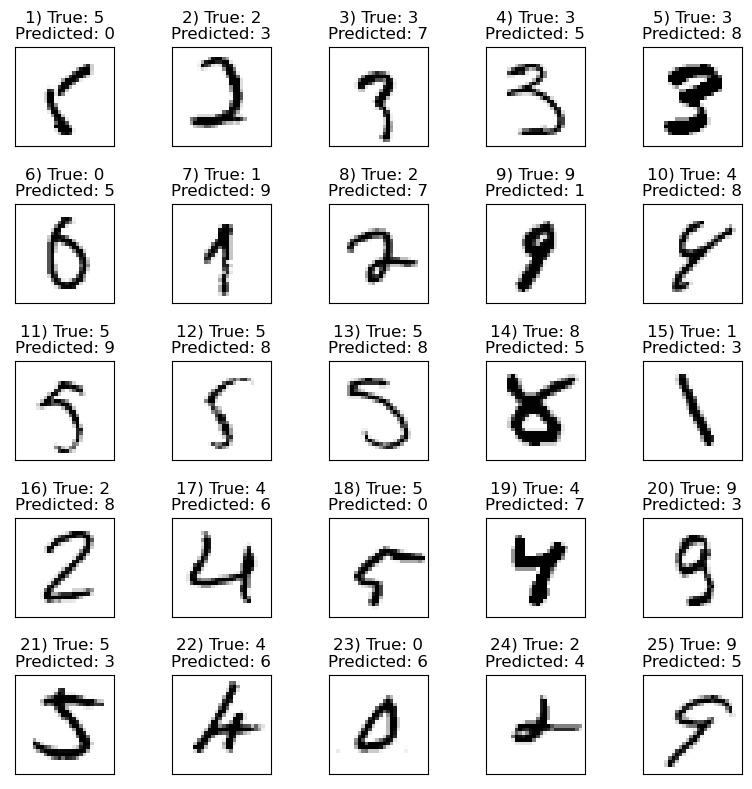

In [22]:
fig, ax = plt.subplots(nrows=5, ncols=5,
                       sharex=True, sharey=True, figsize=(8, 8))
ax = ax.flatten()
for i in range(25):
    img = misclassified_images[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title(f'{i+1}) '
                    f'True: {correct_labels[i]}\n'
                    f'Predicted: {misclassified_labels[i]}')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
#plt.savefig('figures/11_09.png', dpi=300)
plt.show()